In [83]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [4]:
from google.colab import files
uploaded = files.upload()

Saving archive (22).zip to archive (22).zip


In [5]:
import zipfile
import io

# replace 'your_file.zip' with the exact name shown after upload
with zipfile.ZipFile(io.BytesIO(uploaded['archive (22).zip']), 'r') as zip_ref:
    zip_ref.extractall('unzipped_data')

In [34]:
data_dir = "unzipped_data/Face Mask Dataset"

In [60]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [61]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [62]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [63]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [64]:
train_gen = train_datagen.flow_from_directory(
    data_dir + '/Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 10000 images belonging to 2 classes.


In [65]:
val_gen = val_datagen.flow_from_directory(
    data_dir + '/Validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 800 images belonging to 2 classes.


In [66]:
test_gen = test_datagen.flow_from_directory(
    data_dir + '/Test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 992 images belonging to 2 classes.


In [67]:
y_train = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [68]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [69]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=2,
                                 factor=0.5,
                                 min_lr=1e-7,
                                 verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [70]:
history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[lr_reduction, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 427ms/step - accuracy: 0.8838 - loss: 0.2670 - val_accuracy: 0.9900 - val_loss: 0.0371 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 385ms/step - accuracy: 0.9769 - loss: 0.0667 - val_accuracy: 0.9937 - val_loss: 0.0309 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 385ms/step - accuracy: 0.9850 - loss: 0.0495 - val_accuracy: 0.9950 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 120s 384ms/step - accuracy: 0.9866 - loss: 0.0422 - val_accuracy: 0.9950 - val_loss: 0.0244 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9849 - loss: 0.0447
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 392ms/step - accuracy: 0.9849 - loss: 0.0447 - val_accuracy: 0.9937 - val_loss: 0.0231 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 38

In [71]:
for layer in base_model.layers[-75:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),  # lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights_dict,
    callbacks=[lr_reduction, early_stop]
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 178s 475ms/step - accuracy: 0.9187 - loss: 0.2143 - val_accuracy: 0.9812 - val_loss: 0.0497 - learning_rate: 1.0000e-05
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 394ms/step - accuracy: 0.9803 - loss: 0.0507 - val_accuracy: 0.9837 - val_loss: 0.0373 - learning_rate: 1.0000e-05
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 399ms/step - accuracy: 0.9872 - loss: 0.0352 - val_accuracy: 0.9925 - val_loss: 0.0211 - learning_rate: 1.0000e-05
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 395ms/step - accuracy: 0.9907 - loss: 0.0270 - val_accuracy: 0.9937 - val_loss: 0.0180 - learning_rate: 1.0000e-05
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 397ms/step - accuracy: 0.9927 - loss: 0.0207 - val_accuracy: 0.9987 - val_loss: 0.0069 - learning_rate: 1.0000e-05


In [73]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9969 - loss: 0.0164

✅ Test Accuracy: 99.70%


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

Classification Report:

              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



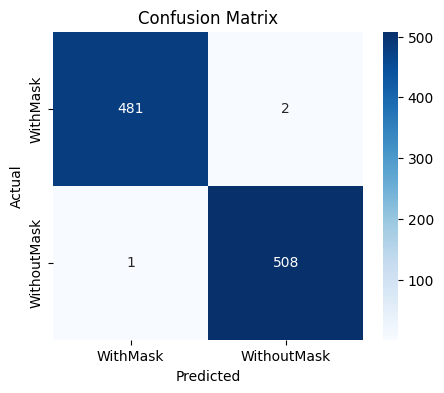

In [75]:
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(test_gen.classes, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [104]:
  def get_gradcam(img_path, model, IMG_SIZE=224, layer_name='block_16_project'):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Grad-CAM model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]

    # Generate heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)  # avoid division by zero

    # Superimpose on original image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (IMG_SIZE, IMG_SIZE))
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))  # remove .numpy()
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    # Plot original + Grad-CAM
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()


In [105]:
import os

test_folder = 'unzipped_data/Face Mask Dataset/Test/WithMask'
print(os.listdir(test_folder))

['Augmented_292_9405685.png', 'Augmented_199_1537768.png', 'Augmented_824_6606851.png', '1835.png', 'Augmented_53_6320831.png', 'Augmented_326_3854988.png', 'Augmented_840_410277.png', 'Augmented_617_8208877.png', '998.png', '754.png', 'Augmented_890_8528242.png', 'Augmented_141_8092740.png', 'Augmented_26_5028003.png', 'Augmented_820_119.png', 'Augmented_317_3224825.png', 'Augmented_398_6983652.png', 'Augmented_142_4240524.png', '385.png', 'Augmented_831_8950035.png', 'Augmented_660_9937342.png', 'Augmented_536_7576091.png', 'Augmented_167_447307.png', 'Augmented_477_1922227.png', 'Augmented_51_2701700.png', '46.png', 'Augmented_654_8030736.png', 'Augmented_406_4576935.png', 'Augmented_854_5503218.png', 'Augmented_367_4095639.png', '408.png', 'Augmented_646_5216553.png', 'Augmented_52_3808930.png', 'Augmented_381_9147363.png', 'Augmented_742_5777738.png', 'Augmented_411_871195.png', 'Augmented_797_8118850.png', 'Augmented_353_5799649.png', 'Augmented_546_8939403.png', 'Augmented_263_1

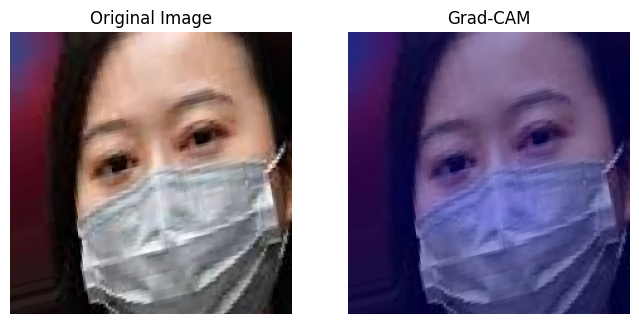

In [106]:
get_gradcam('unzipped_data/Face Mask Dataset/Test/WithMask/Augmented_292_9405685.png', model)

Selected image: unzipped_data/Face Mask Dataset/Test/WithMask/768.png


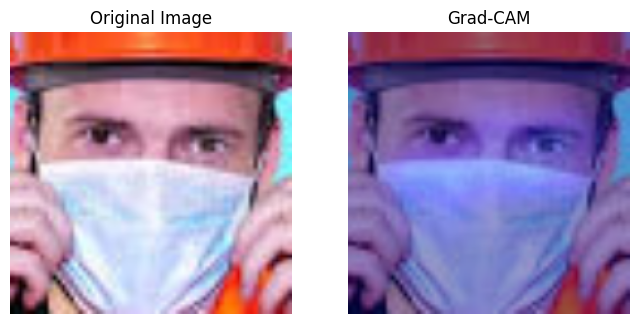

In [107]:
import os, random

test_folder = 'unzipped_data/Face Mask Dataset/Test/WithMask'
img_name = random.choice(os.listdir(test_folder))
img_path = os.path.join(test_folder, img_name)
print("Selected image:", img_path)

get_gradcam(img_path, model)

In [110]:
model.save('MobileNetV2_FaceMaskDetector.h5')